In [ ]:
# import urllib.request
# import os
# import concurrent.futures
# from tqdm import tqdm

# URLS_PATH = "./resources/images_urls.csv"
# OUTPUT_PATH = "./DeepBee/original_images"
# MAX_WORKERS = 5 

# os.makedirs(OUTPUT_PATH, exist_ok=True) 


# with open(URLS_PATH, "r") as file:
#     urls = [i.strip().split(",") for i in file.readlines()]

# def download_image(data):
#     filename, url = data
#     file_path = os.path.join(OUTPUT_PATH, filename)

#     try:
#         urllib.request.urlretrieve(url, file_path)
#         return f"Downloaded: {filename}"
#     except Exception as e:
#         return f"Failed: {filename} - {e}"
# failed_downloads = []
# with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
#     results = list(tqdm(executor.map(download_image, urls), total=len(urls)))
# for result in results:
#     if "Failed" in result:
#         failed_downloads.append(result)
# if failed_downloads:
#     print("\nSome files failed to download:")
#     for fail in failed_downloads:
#         print(fail)


# YOLO to Mask Conversion

This notebook converts YOLO object detection annotations into binary masks for images. The script reads images and their corresponding YOLO label files, then creates and saves masks with rectangles representing detected objects.

## Workflow:
1. **Input Folders:**
   - `image_folder`: Contains image files (`.JPG`, `.png`).
   - `label_folder`: Contains YOLO label files (`.txt`).
   - `mask_folder`: Stores the generated mask images.

2. **Process:**
   - For each label file, the script parses the YOLO annotation (class_id, x_center, y_center, bbox_width, bbox_height).
   - The bounding box is converted to pixel coordinates, and a mask is created with rectangles marking object locations.

3. **Output:**
   - Masks are saved as PNG images in the `mask_folder`.

```python
import os
import cv2
import numpy as np

# Define folders
image_folder = "./Dataset"
label_folder = "./Labels"
mask_folder = "./masks"
os.makedirs(mask_folder, exist_ok=True)

# Function to create mask
def yolo_to_mask(label_path, image_path, mask_path):
    # Read and process the image and label
    ...

# Loop through images and generate masks
for filename in os.listdir(image_folder):
    # Generate masks for valid images and corresponding labels
    ...

print("Masks saved successfully!")


In [ ]:
import os
import cv2
import numpy as np

image_folder = "./Dataset" 
label_folder = "./Labels" 
mask_folder = "./masks"    

os.makedirs(mask_folder, exist_ok=True)

def yolo_to_mask(label_path, image_path, mask_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return
    h, w, _ = image.shape 

    mask = np.zeros((h, w), dtype=np.uint8)

    try:
        with open(label_path, "r") as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Error reading label file: {label_path}, {e}")
        return
    
    for line in lines:
        values = line.strip().split()
        if len(values) != 5:
            print(f"Invalid label format in file: {label_path}")
            continue
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

        x1 = int((x_center - bbox_width / 2) * w)
        y1 = int((y_center - bbox_height / 2) * h)
        x2 = int((x_center + bbox_width / 2) * w)
        y2 = int((y_center + bbox_height / 2) * h)

        cv2.rectangle(mask, (x1, y1), (x2, y2), (255), thickness=-1)

    try:
        cv2.imwrite(mask_path, mask)
        print(f"Mask saved: {mask_path}")
    except Exception as e:
        print(f"Error saving mask: {mask_path}, {e}")

for filename in os.listdir(image_folder):
    if filename.endswith(".JPG") or filename.endswith(".png"):
        base_name = os.path.splitext(filename)[0]
        label_path = os.path.join(label_folder, base_name + ".txt")
        image_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, base_name + ".png")

        if os.path.exists(label_path):
            yolo_to_mask(label_path, image_path, mask_path)
        else:
            print(f"Label file not found: {label_path}")

print("Masks saved successfully!")


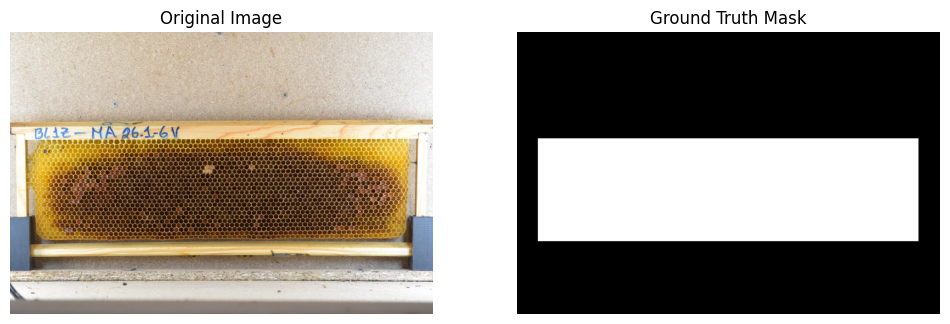

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt

image_folder = "Dataset"
mask_folder = "masks"

image_files = os.listdir(image_folder)
random_image_file = random.choice(image_files)

image_path = os.path.join(image_folder, random_image_file)
mask_path = os.path.join(mask_folder, random_image_file.replace('.JPG', '.png')) 

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')  

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off') 

plt.show()


# Model Setup for Image Segmentation

This notebook prepares a deep learning model for image segmentation using U-Net architecture. It imports necessary libraries, sets up the environment, and prepares for training with data augmentation and a learning rate scheduler.

## Key Libraries:
- **OpenCV & NumPy** for image processing.
- **TensorFlow & Keras** for model building and training.
- **Matplotlib** for visualization.
- **TQDM** for progress bars during training.

## Workflow:
1. **Data Preparation**: Split data into training and validation sets.
2. **Model Architecture**: Build a U-Net model using Conv2D, MaxPooling2D, UpSampling2D, and BatchNormalization layers.
3. **Training**: Use Adam optimizer, `ReduceLROnPlateau` callback, and data augmentation for better generalization.

```python
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
K = tf.keras.backend


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
K = tf.keras.backend

# U-Net Model for Image Segmentation

This notebook demonstrates the end-to-end process of training a U-Net model for image segmentation, including data preprocessing, augmentation, model definition, and custom loss functions. The primary goal is to segment objects in images using a deep learning model.

## Key Steps:

1. **Data Preprocessing**:
   - **Images**: 
     - Read images from the dataset folder.
     - Resize to 256x256 pixels.
     - Normalize pixel values to the range [0, 1].
   - **Masks**:
     - Read masks from the masks folder (grayscale).
     - Resize and normalize them similarly.

2. **Data Augmentation**:
   - Apply random transformations (rotation, shift, shear, zoom, flip) to the images and masks using `ImageDataGenerator`. This helps improve model generalization.

3. **Train-Validation Split**:
   - Split the data into 90% training and 10% validation using `train_test_split`.

4. **Custom Loss Function**:
   - **Dice Loss**: Used for segmentation tasks to handle class imbalance, emphasizing the overlap between predicted and true masks.

5. **Model Architecture (U-Net)**:
   - **Encoder**: A series of convolutional layers followed by max-pooling to downsample.
   - **Decoder**: Upsampling with concatenation to restore image resolution, followed by convolutions.
   - **Final Output**: A single channel output using a sigmoid activation for binary segmentation.

6. **Model Compilation**:
   - Use the **Adam** optimizer with a learning rate of `1e-4`.
   - Compile the model using **Dice loss** and track accuracy.

```python
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
K = tf.keras.backend

# Preprocessing functions for images and masks
def preprocess_images(image_folder):
    ...

def preprocess_masks(mask_folder):
    ...

# Data augmentation setup
data_gen_args = dict(...)

# Dice loss function
def dice_loss(y_true, y_pred):
    ...

# U-Net model definition
def conv_block(input_tensor, num_filters):
    ...

def unet_model(input_size=(256, 256, 3)):
    ...


In [3]:
image_folder = "Dataset"
mask_folder = "masks"

def preprocess_images(image_folder):
    images = []
    file_list = os.listdir(image_folder)
    for filename in tqdm(file_list, desc="Processing Images"):
        img = cv2.imread(os.path.join(image_folder, filename))
        if img is not None:
            img = cv2.resize(img, (256, 256))
            img = img / 255.0
            images.append(img)
    return np.array(images)

def preprocess_masks(mask_folder):
    masks = []
    file_list = os.listdir(mask_folder)
    for filename in tqdm(file_list, desc="Processing Masks"):
        mask = cv2.imread(os.path.join(mask_folder, filename), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            mask = cv2.resize(mask, (256, 256))
            mask = mask / 255.0
            masks.append(mask)
    return np.array(masks).reshape(-1, 256, 256, 1)

images = preprocess_images(image_folder)
masks = preprocess_masks(mask_folder)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=42)

data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#U-Net Model
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = conv_block(pool4, 1024)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = conv_block(up6, 512)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = conv_block(up7, 256)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = conv_block(up8, 128)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = conv_block(up9, 64)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy'])
    return model


Processing Masks: 100%|██████████| 388/388 [00:47<00:00,  8.19it/s]


# Model Training and Evaluation

This section covers the training and evaluation of the U-Net model for image segmentation.

## Model Training:
1. **Model Summary**: Displays the architecture of the U-Net model.
2. **Learning Rate Scheduler**: Uses `ReduceLROnPlateau` to reduce the learning rate if validation loss plateaus, with a minimum learning rate of `1e-6`.
3. **Data Generators**: 
   - `train_generator`: Augmented training data.
   - `val_generator`: Augmented validation data.
4. **Training**: The model is trained for 50 epochs with a batch size of 8, using the augmented data generators.

```python
model = unet_model()
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

train_generator = image_datagen.flow(X_train, y_train, batch_size=8)
val_generator = image_datagen.flow(X_val, y_val, batch_size=8)

model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[reduce_lr])


In [4]:
# Model Training
model = unet_model()
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

train_generator = image_datagen.flow(X_train, y_train, batch_size=8)
val_generator = image_datagen.flow(X_val, y_val, batch_size=8)

model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[reduce_lr])

# Model Evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 31,402,497 (119.79 MB)

 Trainable params: 31,390,721 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.7242 - loss: 0.2582 - val_accuracy: 0.7922 - val_loss: 0.2801 - learning_rate: 1.0000e-04
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 509ms/step - accuracy: 0.8372 - loss: 0.1366 - val_accuracy: 0.4176 - val_loss: 0.9028 - learning_rate: 1.0000e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 511ms/step - accuracy: 0.8550 - loss: 0.1214 - val_accuracy: 0.4176 - val_loss: 0.9984 - learning_rate: 1.0000e-04
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 514ms/step - accuracy: 0.8554 - loss: 0.1207 - val_accuracy: 0.6222 - val_loss: 0.2468 - learning_rate: 1.0000e-04
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 513ms/step - accuracy: 0.8583 - loss: 0.1188 - val_accuracy: 0.7197 - val_loss: 0.1997 - learning_rate: 1.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 513ms/step - accuracy: 0.8625 - loss: 0.1145 - val_accuracy: 0.7249 - val_loss: 0.1985 - learning_rate: 1.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 512ms/step - accuracy: 0.8544

# Sample Predictions

This section visualizes the model's predictions on random samples from the validation set.

## Prediction and Visualization:
1. **Random Sample**: A random image from the validation set is selected.
2. **Model Prediction**: The model predicts the mask for the selected image.
3. **Contours**: The predicted mask is processed to identify contours and display them on the image.
4. **Plot**: A comparison between the original image, ground truth mask, and predicted mask with bounding boxes is shown.

```python
def plot_predictions(model, X_val, y_val):
    idx = np.random.randint(0, len(X_val))
    img = X_val[idx]
    mask = y_val[idx]
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    
    contours, _ = cv2.findContours((pred_mask.squeeze() > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_box = (img * 255).astype(np.uint8)
    cv2.drawContours(img_with_box, contours, -1, (0, 255, 0), 2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(img_with_box)
    axes[2].set_title("Predicted Mask Bounding Box")
    plt.show()

plot_predictions(model, X_val, y_val)

print("Done!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


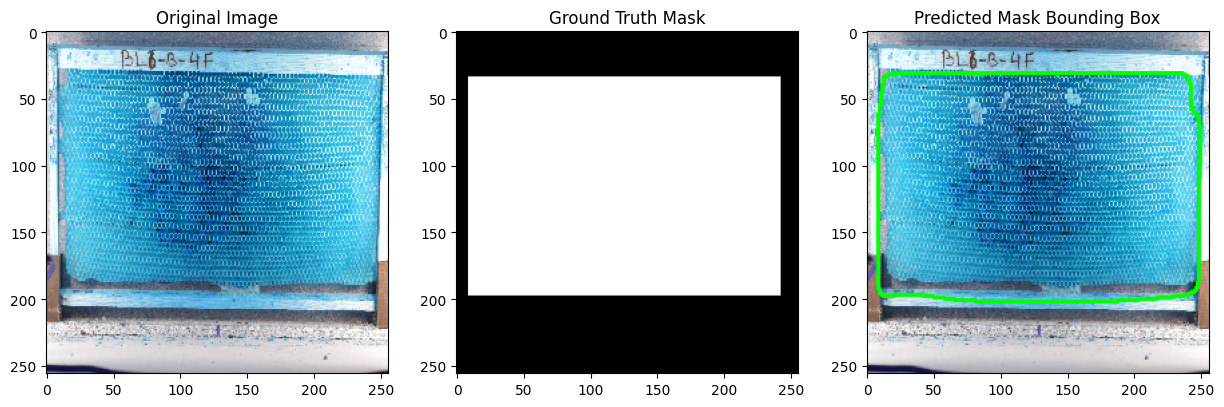

Done!


In [12]:
#Sample Predictions
def plot_predictions(model, X_val, y_val):
    idx = np.random.randint(0, len(X_val))
    img = X_val[idx]
    mask = y_val[idx]
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    
    contours, _ = cv2.findContours((pred_mask.squeeze() > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_box = (img * 255).astype(np.uint8)
    cv2.drawContours(img_with_box, contours, -1, (0, 255, 0), 2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(img_with_box)
    axes[2].set_title("Predicted Mask Bounding Box")
    plt.show()

plot_predictions(model, X_val, y_val)

print("Done!")


# Model Evaluation: Precision, Recall, and F1 Score

This section evaluates the model using precision, recall, and F1 score. It calculates the Mean Average Precision (mAP) and F1 score for binary segmentation tasks.

## Evaluation Metrics:
1. **Precision-Recall Curve**: The model's precision and recall are calculated across different thresholds.
2. **Mean Average Precision (mAP)**: The average precision score across all thresholds, indicating the model's accuracy in distinguishing positive class pixels.
3. **F1 Score**: The harmonic mean of precision and recall, providing a single metric for evaluating segmentation performance.

```python
import numpy as np
import cv2
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

def evaluate_model(model, X_val, y_val):
    y_true_list = []
    y_pred_list = []
    
    for i in range(len(X_val)):
        img = np.expand_dims(X_val[i], axis=0)
        pred_mask = model.predict(img)[0].squeeze()
        true_mask = y_val[i].squeeze()
        
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
        true_mask_bin = (true_mask > 0.5).astype(np.uint8)
        
        y_true_list.append(true_mask_bin.flatten())
        y_pred_list.append(pred_mask_bin.flatten())
    
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    mAP = average_precision_score(y_true, y_pred)
    
    f1 = f1_score(y_true, y_pred)
    
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return mAP, f1

# Run evaluation
mAP, f1 = evaluate_model(model, X_val, y_val)


In [13]:
import numpy as np
import cv2
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

def evaluate_model(model, X_val, y_val):
    y_true_list = []
    y_pred_list = []
    
    for i in range(len(X_val)):
        img = np.expand_dims(X_val[i], axis=0)
        pred_mask = model.predict(img)[0].squeeze()
        true_mask = y_val[i].squeeze()
        
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
        true_mask_bin = (true_mask > 0.5).astype(np.uint8)
        
        y_true_list.append(true_mask_bin.flatten())
        y_pred_list.append(pred_mask_bin.flatten())
    
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    mAP = average_precision_score(y_true, y_pred)
    
    f1 = f1_score(y_true, y_pred)
    
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return mAP, f1

# Run evaluation
mAP, f1 = evaluate_model(model, X_val, y_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [6]:
model.save("unet_model.h5")
print("Model saved as 'unet_model.h5'")
def load_trained_model():
    return load_model("unet_model.h5", custom_objects={"dice_loss": dice_loss})

# Evaluate Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Model saved as 'unet_model.h5'
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8299 - loss: 0.1415
Validation Loss: 0.1392, Validation Accuracy: 0.8324
